In [149]:
## labptptm2 data using
import numpy as np
from collections import namedtuple
from commplax import comm
import labptptm2

dat_grp, sup_grp = labptptm2.select(1, 0, 4, 2)
'''
the 4 input arguments of select identify each collected data file:
arg#1: int, random source sequence identifier, which can be either 1 or 2
arg#2: int, launched power in dBm unit, which must be a member of [-5, -4, -3, -2, -1, 0, 1, 2, 3]
arg#3: int, channel index, which is member of [1, 2, 3, 4, 5, 6, 7]
arg#4: int, index of scope captures under the same link configuration, a member of [1, 2, 3]
select returns 2 objects, a list of data groups and a list of supplymentary data groups.
Each data group contains recieved samples (resampled to 2 samples/symbol), synchronized sent symbols and attributes; each supplymentary data group contains auxiliary infomation such as estimated frequency offset and chromatic dispersion.
multi-selection is supported by a list of specifications:
dat_grp, sup_grp = labptptm2.select(1, [0, 1], [4, 7], 2)
since we only input a single specification, the returned list has only 1 group:
'''
print(list(dat_grp[0].array_keys()))
print(dat_grp[0]['recv'])
print(dat_grp[0].attrs['channels'])
dict(dat_grp[0].attrs)


['recv', 'sent']
<zarr.core.Array '/1125km_SSMF/src1/0dBm_ch4_2/recv' (4500000, 2) complex64>
7


{'baudrate': 36000000000.0,
 'channelindex': 4,
 'channels': 7,
 'distance': 1125000.0,
 'lpdbm': 0.0,
 'lpw': 0.001,
 'modformat': '16QAM',
 'polmux': 1,
 'samplerate': 72000000000.0,
 'spans': 15,
 'srcid': 'src1'}

In [145]:
type(dat_grp)

list

In [94]:
print(dat_grp[0].info)
print(dat_grp[0]['recv'].info)
dict(dat_grp[0])

Name             : /1125km_SSMF/src1/0dBm_ch4_2
Type             : zarr.hierarchy.Group
Read-only        : False
Store type       : zarr.storage.ConsolidatedMetadataStore
Chunk store type : zarr.storage.FSStore
No. members      : 2
No. arrays       : 2
No. groups       : 0
Arrays           : recv, sent

Name               : /1125km_SSMF/src1/0dBm_ch4_2/recv
Type               : zarr.core.Array
Data type          : complex64
Shape              : (4500000, 2)
Chunk shape        : (140625, 1)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.ConsolidatedMetadataStore
Chunk store type   : zarr.storage.FSStore
No. bytes          : 72000000 (68.7M)
Chunks initialized : 64/64



{'recv': <zarr.core.Array '/1125km_SSMF/src1/0dBm_ch4_2/recv' (4500000, 2) complex64>,
 'sent': <zarr.core.Array '/1125km_SSMF/src1/0dBm_ch4_2/sent' (2250000, 2) complex64>}

In [151]:
dict(sup_grp[0].attrs)

{'cd': 18.451}

In [154]:
dict(sup_grp[0])

{'nfo': <zarr.core.Array '/supdata/src1/0dBm_ch4_2/nfo' (4500000,) float64>}

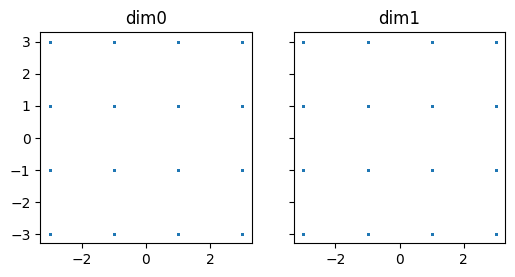

In [74]:
cplt.scatter(dat_grp[0]['sent'][0:1000])

In [9]:
## labptptm1 data using
import numpy as np
import matplotlib.pyplot as plt
from labptptm1 import dataset as dat
from commplax import comm, xcomm, equalizer as eq, plot as cplt

ds = dat['815km_SSMF/DP16QAM_RRC0.2_28GBd_1ch']

y = ds['LP-6_5/recv'][:200000]
x = dat['source/16QAM65536/src'][:]
sr = ds.attrs['samplerate']   # symbol rate
br = ds.attrs['baudrate']     # bit rate
dist = ds.attrs['distance']
spans = ds.attrs['spans']
mf = ds.attrs['modformat']      # modulate formate
lpw = ds['LP-6_5'].attrs['lpw'] # launched power
         
# meta data
print('shape of y: %s (received waveforms, resampled to 2 samples/symbol): ' % str(y.shape))
print('shape of x: %s (source symbols): ' % str(x.shape))
print('sample rate: %.1f GHz' % (sr / 1e9))
print('baud rate: %.1f GBd' % (br / 1e9))
print('launched power: %.3f mW' % (lpw * 1e3))
print('link distance: %.1f km (measured)' % (dist / 1e3))
print('number of spans: %d' % spans)

In [52]:
# DC-block and normalize raw signal
y -= np.mean(y, axis=0)
y =  xcomm.normpower(y, real=True) / np.sqrt(2)
 
# CD measurement
CD = 13.6
# CD = xcomm.measure_cd(y[10000:30000, 0], sr, bins=2000)[0]  # slow on CPU
print('estimated accumulated CD = %.4g s/m' % CD)

z_cdc = eq.cdcomp(y, sr, CD)  # CD compensaton
z_mimo = eq.modulusmimo(z_cdc, taps=19, lr=2**-14)[0]  # polarization demultiplexing
z_foe = eq.qamfoe(z_mimo)[0]  # frequency offset equalization
z_cpr = eq.ekfcpr(z_foe)[0]  # carrier phase recovery

estimated accumulated CD = 13.6 s/m


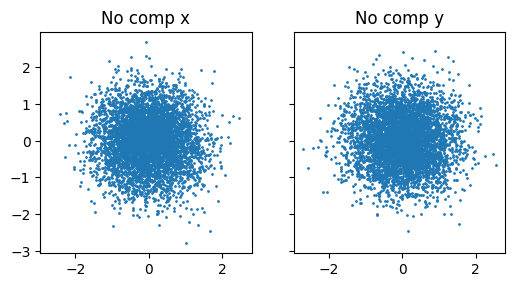

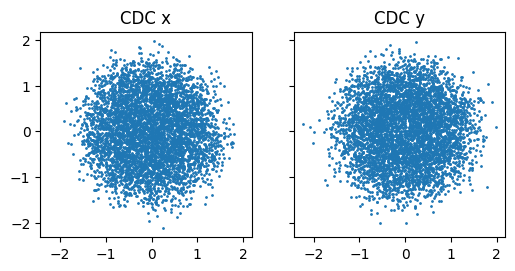

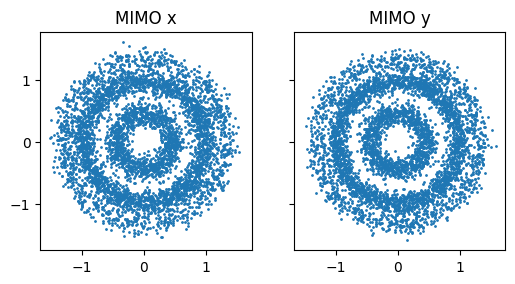

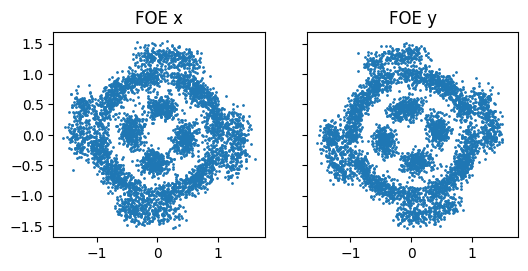

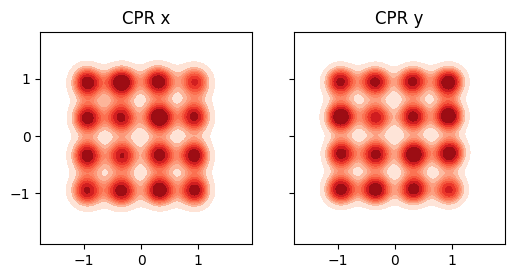

In [53]:
cplt.scatter(y[90000:95000],title=['No comp x','No comp y'])
cplt.scatter(z_cdc[90000:95000], title=['CDC x','CDC y'])
cplt.scatter(z_mimo[90000:95000], title=['MIMO x','MIMO y'])
cplt.scatter(z_foe[90000:95000], title=['FOE x','FOE y'])
cplt.scatter(z_cpr[90000:95000], kde=True, title=['CPR x','CPR y']) # kdeplot takes more time

In [34]:
# aligning sent symbols to calc. BER
x_rep = xcomm.repalign(z_cpr, x)

# removing phase ambiguity and rescale signal
x_hat = xcomm.alignphase(z_cpr, x_rep) * xcomm.qamscale(mf)

# get metrics
qot = comm.qamqot(x_hat, x_rep, eval_range=(50000, -1000))
qot

,BER,QSq,SNR
dim0,0.001148,9.683196,16.524351
dim1,0.000434,10.449816,17.389026
total,0.000791,9.991743,16.935250


In [165]:
## train net work
import numpy as np
from collections import namedtuple
from commplax import comm
import labptptm2

Dataset = namedtuple('Data', ['y', 'x', 'w0', 'a'])

labptptm2.select([1, 2], 0, 4, 1) # 1 dBm

def loaddata(src: int, lp: int, ch: int, rep: int, num=150):
    ''' dataloader of LabPtPTm2 dataset
        more info: https://github.com/remifan/LabPtPTm2

        Args:
            src: QRBS source index
            lp: launched power in dBm
            ch: channel index
            rep: index of scope captures
            num: number of symbols to load

        Returns:
            dataset stored in namedtuple: (2 sample/symbol waveforms,
                                           aligned sent symbols,
                                           monitored initial FO,
                                           data attributes)
    '''

    with labptptm2.select(src, lp, ch, rep)[0][0] as fd:
        y = fd['recv'][:num * 2]
        x = fd['sent'][:num]
        a = dict(zip(fd.attrs.keys(), fd.attrs.values())) # extract hdf attributes
    y -= np.mean(y, axis=0) # block DC
    y = comm.normpower(y, real=True) / np.sqrt(2) # normalize power
    x /= comm.qamscale(a['modformat']) # rescale ground truth

    with labptptm2.select(src, lp, ch, rep)[1][0] as fd:
        nfo = fd['nfo'][...] # coarsely monitored frequency offset evolution normalized to sample period
        a['CD'] = fd.attrs['cd'] # measured CD

    w0 = nfo[0] * 2 # initial FO at symbol period used to initialize FOE

    return Dataset(y, x, w0, a)

In [172]:
ds_train, ds_test = loaddata(1, 0, 4, 1,num=1500000), loaddata(2, 0, 4, 1,num=1500000)

In [189]:
ds_train.w0

0.026449523866176605

In [173]:
from jax import numpy as jnp, random, jit, value_and_grad
import flax
from commplax import util, comm, cxopt, op
from commplax.module import core, layer
import numpy as np
from functools import partial
from collections import namedtuple
from tqdm.auto import tqdm
from typing import Any, Optional, Union


Model = namedtuple('Model', 'model initvar overlaps')
Array = Any
Dict = Union[dict, flax.core.FrozenDict]


def make_base_model(steps: int = 3,
                    dtaps: int = 261,
                    ntaps: int = 41,
                    rtaps: int = 61,
                    init_fn: tuple = (core.delta, core.gauss),
                    w0 = 0.,
                    mode: str = 'train'):
    '''
    model structure: DBP variants (backprop optim.) + 
                     adaptive Kalman-filter based FOE (self updating) + 
                     residual static filter (backprop optim.) + 
                     adaptive DDLMS-MIMO (self updating)
    make base model that derives DBP, FDBP, EDBP, GDBP depending on
    specific initialization method and trainable parameters defined
    by trainer.

    Args:
        steps: GDBP steps/layers
        dtaps: D-filter length
        ntaps: N-filter length
        rtaps: R-filter length
        init_fn: a tuple contains a pair of initializer for D-filter and N-filter
        mode: 'train' or 'test'

    Returns:
        A layer object
    '''

    _assert_taps(dtaps, ntaps, rtaps)

    d_init, n_init = init_fn

    if mode == 'train':
        # configure mimo to its training mode
        mimo_train = True
    elif mode == 'test':
        # mimo operates at training mode for the first 200000 symbols,
        # then switches to tracking mode afterwards
        mimo_train = cxopt.piecewise_constant([200000], [True, False])
    else:
        raise ValueError('invalid mode %s' % mode)

    base = layer.Serial(
        layer.FDBP(steps=steps,
                   dtaps=dtaps,
                   ntaps=ntaps,
                   d_init=d_init,
                   n_init=n_init),
        layer.BatchPowerNorm(mode=mode),
        layer.MIMOFOEAf(name='FOEAf',
                        w0=w0,
                        train=mimo_train,
                        preslicer=core.conv1d_slicer(rtaps),
                        foekwargs={}),
        layer.vmap(layer.Conv1d)(name='RConv', taps=rtaps),  # vectorize column-wise Conv1D
        layer.MIMOAF(train=mimo_train))  # adaptive MIMO layer
    return base


def _assert_taps(dtaps, ntaps, rtaps, sps=2):
    ''' we force odd taps to ease coding '''
    assert dtaps % sps, f'dtaps must be odd number, got {dtaps} instead'
    assert ntaps % sps, f'ntaps must be odd number, got {ntaps} instead'
    assert rtaps % sps, f'rtaps must be odd number, got {rtaps} instead'


def fdbp_init(a: dict,
              xi: float = 1.1,
              steps: Optional[int] = None):
    '''
        initializer for the base model

        Args:
            xi: NLC scaling factor
            steps: GDBP steps, used to calculate the theoretical profiles of D- and N-filters

        Returns:
            a pair of functions to initialize D- and N-filters
    '''

    def d_init(key, shape, dtype=jnp.complex64):
        dtaps = shape[0]
        d0, _ = comm.dbp_params(
            a['samplerate'],
            a['distance'] / a['spans'],
            a['spans'],
            dtaps,
            a['lpdbm'] - 3,  # rescale as input power which has been norm to 2 in dataloader
            virtual_spans=steps)
        return d0[0, :, 0]

    def n_init(key, shape, dtype=jnp.float32):
        dtaps = shape[0]
        _, n0 = comm.dbp_params(
            a['samplerate'],
            a['distance'] / a['spans'],
            a['spans'],
            dtaps,
            a['lpdbm'] - 3,  # rescale
            virtual_spans=steps)

        return xi * n0[0, 0, 0] * core.gauss(key, shape, dtype)

    return d_init, n_init


def model_init(data: Dataset,
               base_conf: dict,
               sparams_flatkeys: list,
               n_symbols: int = 2000,
               sps : int = 2):
    ''' initialize model from base template, generating CDC, DBP, EDBP, FDBP, GDBP
    depending on given N-filter length and trainable parameters

    Args:
        data:
        base_conf: a dict of kwargs to make base model, see `make_base_model`
        sparams_flatkeys: a list of keys contains the static(nontrainable) parameters.
            For example, assume base model has parameters represented as nested dict
            {'color': 'red', 'size': {'width': 1, 'height': 2}}, its flatten layout is dict
             {('color',): 'red', ('size', 'width',): 1, ('size', 'height'): 2}, a sparams_flatkeys
             of [('color',): ('size', 'width',)] means 'color' and 'size/width' parameters are static.
            regexp key is supportted.
        n_symbols: number of symbols used to initialize model, use the minimal value greater than channel
            memory
        sps: sample per symbol. Only integer sps is supported now.

    Returns:
        a initialized model wrapped by a namedtuple
    '''

    model = make_base_model(**base_conf, w0=data.w0)
    y0 = data.y[:n_symbols * sps]
    rng0 = random.PRNGKey(0)
    z0, v0 = model.init(rng0, core.Signal(y0))
    ol = z0.t.start - z0.t.stop
    sparams, params = util.dict_split(v0['params'], sparams_flatkeys)
    state = v0['af_state']
    aux = v0['aux_inputs']
    const = v0['const']
    return Model(model, (params, state, aux, const, sparams), ol)


def loss_fn(model: layer.Layer,
            params: Dict,
            state: Dict,
            y: Array,
            x: Array,
            aux: Dict,
            const: Dict,
            sparams: Dict):
    ''' loss function

        Args:
            model: model returned by `model_init`
            params: trainable parameters
            state: model state
            y: transmitted waveforms
            x: aligned sent symbols
            aux: auxiliary input
            const: contants (internal info generated by model)
            sparams: static parameters

        Return:
            loss, updated model state
    '''

    params = util.dict_merge(params, sparams)
    z, updated_state = model.apply(
        {
            'params': params,
            'aux_inputs': aux,
            'const': const,
            **state
        }, core.Signal(y))
    loss = jnp.mean(jnp.abs(z.val - x[z.t.start:z.t.stop])**2)
    return loss, updated_state


@partial(jit, backend='cpu', static_argnums=(0, 1))
def update_step(model: layer.Layer,
                opt: cxopt.Optimizer,
                i: int,
                opt_state: tuple,
                model_state: Dict,
                y: Array,
                x: Array,
                aux: Dict,
                const: Dict,
                sparams: Dict):
    ''' single backprop step

        Args:
            model: model returned by `model_init`
            opt: optimizer
            i: iteration counter
            opt_state: optimizer state
            model_state: model state
            y: transmitted waveforms
            x: aligned sent symbols
            aux: auxiliary input
            const: contants (internal info generated by model)
            sparams: static parameters

        Return:
            loss, updated model state
    '''

    params = opt.params_fn(opt_state)
    (loss, model_state), grads = value_and_grad(
        loss_fn, argnums=1, has_aux=True)(model, params, model_state, y, x,
                                          aux, const, sparams)
    opt_state = opt.update_fn(i, grads, opt_state)
    return loss, opt_state, model_state


def get_train_batch(ds: Dataset,
                    batchsize: int,
                    overlaps: int,
                    sps: int = 2):
    ''' generate overlapped batch input for training

        Args:
            ds: dataset
            batchsize: batch size in symbol unit
            overlaps: overlaps in symbol unit
            sps: samples per symbol

        Returns:
            number of symbols,
            zipped batched triplet input: (recv, sent, fomul)
    '''

    flen = batchsize + overlaps
    fstep = batchsize
    ds_y = op.frame_gen(ds.y, flen * sps, fstep * sps)
    ds_x = op.frame_gen(ds.x, flen, fstep)
    n_batches = op.frame_shape(ds.x.shape, flen, fstep)[0]
    return n_batches, zip(ds_y, ds_x)


def train(model: Model,
          data: Dataset,
          batch_size: int = 500,
          n_iter=None,
          opt: cxopt.Optimizer = cxopt.adam(cxopt.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6]))):
    ''' training process (1 epoch)

        Args:
            model: Model namedtuple return by `model_init`
            data: dataset
            batch_size: batch size
            opt: optimizer

        Returns:
            yield loss, trained parameters, model state
    '''

    params, model_state, aux, const, sparams = model.initvar
    opt_state = opt.init_fn(params)

    n_batch, batch_gen = get_train_batch(data, batch_size, model.overlaps)
    n_iter = n_batch if n_iter is None else min(n_iter, n_batch)

    for i, (y, x) in tqdm(enumerate(batch_gen),
                             total=n_iter, desc='training', leave=False):
        if i >= n_iter: break
        aux = core.dict_replace(aux, {'truth': x})
        loss, opt_state, model_state = update_step(model.model, opt, i, opt_state,
                                                   model_state, y, x, aux,
                                                   const, sparams)
        yield loss, opt.params_fn(opt_state), model_state


def test(model: Model,
         params: Dict,
         data: Dataset,
         eval_range: tuple=(0, -1000)):
    ''' testing, a simple forward pass

        Args:
            model: Model namedtuple return by `model_init`
        data: dataset
        eval_range: interval which QoT is evaluated in, assure proper eval of steady-state performance

        Returns:
            evaluated matrics and equalized symbols
    '''

    state, aux, const, sparams = model.initvar[1:]
    aux = core.dict_replace(aux, {'truth': data.x})

    z, _ = jit(model.model.apply,
               backend='cpu')({
                   'params': util.dict_merge(params, sparams),
                   'aux_inputs': aux,
                   'const': const,
                   **state
               }, core.Signal(data.y))
    metric = snrstat(z.val,
                     data.x[z.t.start:z.t.stop],
                     scale=comm.qamscale(data.a['modformat']),
                     eval_range=eval_range)
    return metric, z


def snrstat(y, x, frame_size=10000, L=None, eval_range=(0, 0), scale=1):
    assert y.shape[0] == x.shape[0]
    y = y[eval_range[0]: y.shape[0] + eval_range[1] if eval_range[1] <= 0 else eval_range[1]] * scale
    x = x[eval_range[0]: x.shape[0] + eval_range[1] if eval_range[1] <= 0 else eval_range[1]] * scale
    return comm.qamqot_local(y, x, frame_size, L)['SNR'][:, 2]

In [174]:
def init_models(data: Dataset, **kwargs):
  ''' make CDC and DBP's derivatives
      all methods has trainable R-filter to maximize their linear equalization performance
      cdc: static D-filter, no NLC
      dbp: static D-filter, scalar manually optimized NLC factor
      fdbp: static D-filter, static N-filter scaled by manually optimized NLC factor
      edbp: static D-filter, tap-by-tap optimizable/trainable N-filter
      gdbp: tap-by-tap optimizable/trainable D-filter and N-filter
  '''
  
  mode = kwargs.get('mode', 'train')
  dtaps = kwargs.get('dtaps', 261)
  ntaps = kwargs.get('ntaps', 41)
  rtaps = kwargs.get('rtaps', 61)
  xi = kwargs.get('xi', 1.1)
  pinit = partial(fdbp_init, data.a, steps=3)
  minit = partial(model_init, data)

  cdc  = minit({'mode': mode, 'ntaps': 1,     'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=0.0)},  [('fdbp_0',)])
  dbp  = minit({'mode': mode, 'ntaps': 1,     'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=0.15)}, [('fdbp_0',)])
  fdbp = minit({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=xi)},   [('fdbp_0',)])
  edbp = minit({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=xi)},   [('fdbp_0', r'DConv_\d')])
  gdbp = minit({'mode': mode, 'ntaps': ntaps, 'dtaps': dtaps, 'rtaps': rtaps, 'init_fn': pinit(xi=xi)},   [])
  return cdc, dbp, fdbp, edbp, gdbp


models_train = init_models(ds_train)
models_test = init_models(ds_test, mode='test')

In [3]:
import torch
x = torch.rand(3)

In [5]:
x
y = x

In [6]:
y = x+1

In [8]:
x

tensor([0.8101, 0.7601, 0.4598])